In [244]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats
import math
# from statsmodels.stats.weightstats import ztest

from utils.read_data import get_values



In [225]:
try:
    data_msl = np.squeeze(get_values('msl',wind=1))
    data_t2m = np.squeeze(get_values('t2m',wind=1))

except:
    print("dataset not available")

In [226]:
assigments_msl = np.load("model_weights/assignments_msl_30_bs512_wind4.npy") #mean sea level pressure cluster
assigments_t2m = np.load("model_weights/assignments_t2m_30_bs512_wind4.npy") #2m temperature cluster

combined_data = np.vstack((assigments_msl, assigments_t2m)).T

timseries = pd.date_range('01-01-1983','31-12-2023',periods=assigments_t2m.shape[0]).round('h')

assigments = pd.DataFrame(combined_data,index=timseries,columns=['msl','t2m'])
assigments['year_month'] = assigments.index.to_period("M")

assigments.head()

,msl,t2m,year_month
1983-01-01 00:00:00,19,11,1983-01
1983-01-01 03:00:00,25,5,1983-01
1983-01-01 06:00:00,21,5,1983-01
1983-01-01 09:00:00,25,10,1983-01
1983-01-01 12:00:00,14,3,1983-01


In [227]:
# el nino data
url = "https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt"

elnino = pd.read_csv(url, sep="\s+")
elnino['datetime'] = pd.to_datetime(elnino['YR'].astype(int).astype(str) +\
                                     elnino['MON'].astype(int).astype(str), format='%Y%m')

elnino = elnino.set_index("datetime")[['ANOM']]
elnino.index=pd.to_datetime(elnino.index).to_period("M")

# anom = 0.5
anom = 1
elnino.loc[elnino['ANOM']>anom,'indicator'] = 1 #el nino
elnino.loc[elnino['ANOM']<-anom,'indicator'] = 2 #la nina
elnino['indicator'] = elnino['indicator'].fillna(0) #nothing

#join all 
elnino = assigments.join(elnino,on="year_month")
elnino.head(10)

,msl,t2m,year_month,ANOM,indicator
1983-01-01 00:00:00,19,11,1983-01,2.32,1.0
1983-01-01 03:00:00,25,5,1983-01,2.32,1.0
1983-01-01 06:00:00,21,5,1983-01,2.32,1.0
1983-01-01 09:00:00,25,10,1983-01,2.32,1.0
1983-01-01 12:00:00,14,3,1983-01,2.32,1.0
1983-01-01 15:00:00,25,3,1983-01,2.32,1.0
1983-01-01 18:00:00,21,3,1983-01,2.32,1.0
1983-01-01 21:00:00,24,9,1983-01,2.32,1.0
1983-01-02 00:00:00,24,17,1983-01,2.32,1.0
1983-01-02 03:00:00,19,5,1983-01,2.32,1.0


In [228]:
# fig, ax = plt.subplots(len(np.unique(assigments_msl)), 3,
#     figsize=(20, len(np.unique(assigments_msl))*4))

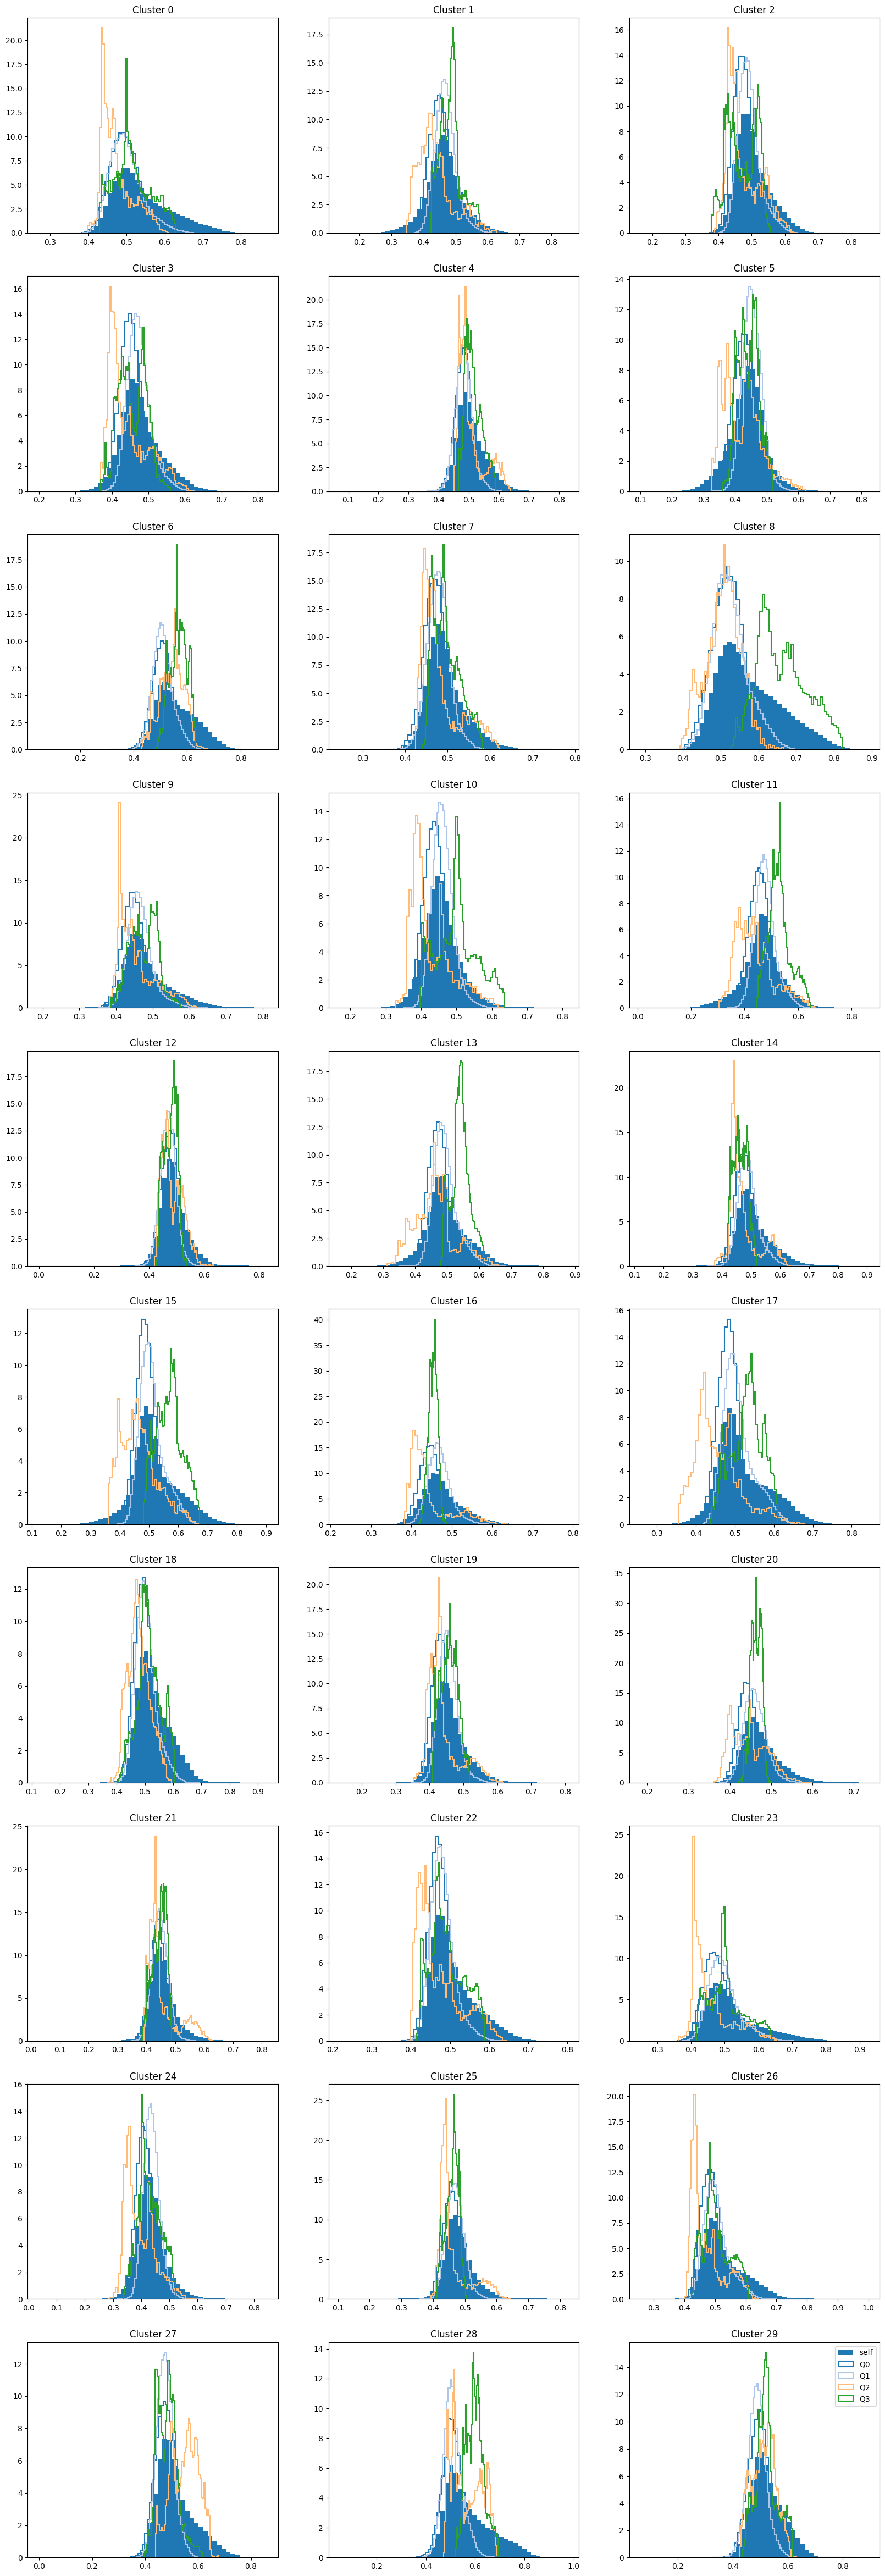

In [242]:
def plot_clusters(data, assigments):


    colors_c = [plt.colormaps['tab20'](c) for c in np.linspace(0, 4)]
    n_bins=50

    fig, ax = plt.subplots(len(np.unique(assigments))//3, 3, figsize=(20, len(np.unique(assigments))*2))
    col, row = 0, 0

    for cluster in np.unique(assigments):

        cur_asg = np.where(assigments == cluster)[0]
        cur_images = data[cur_asg].copy()

        h, w = cur_images.shape[1:]
        h_new, w_new = h//2, w//2

        q1 = cur_images[:,:h_new,:w_new]
        q2 = cur_images[:,:h_new,w_new:]
        q3 =  cur_images[0,h_new:,:w_new]
        q4 = cur_images[0,h_new:,w_new:]

        _ = ax[row,col].hist(cur_images.ravel(),density=True,
                    bins=n_bins,alpha = 1,label= 'self')

        for num, quad in enumerate([q1,q2,q3,q4]):

            _ = ax[row,col].hist(quad.ravel(),density=True,
                    bins=n_bins,histtype='step',
                    color=colors_c[num],label= f'Q{num}',linewidth=1.5)

        ax[row,col].set_title(f'Cluster {cluster}')

        if col < 2:
            col+=1
        else: 
            col=0
            row+=1

    plt.legend()
    plt.show()

plot_clusters(data_msl, assigments_msl)

## Temperature

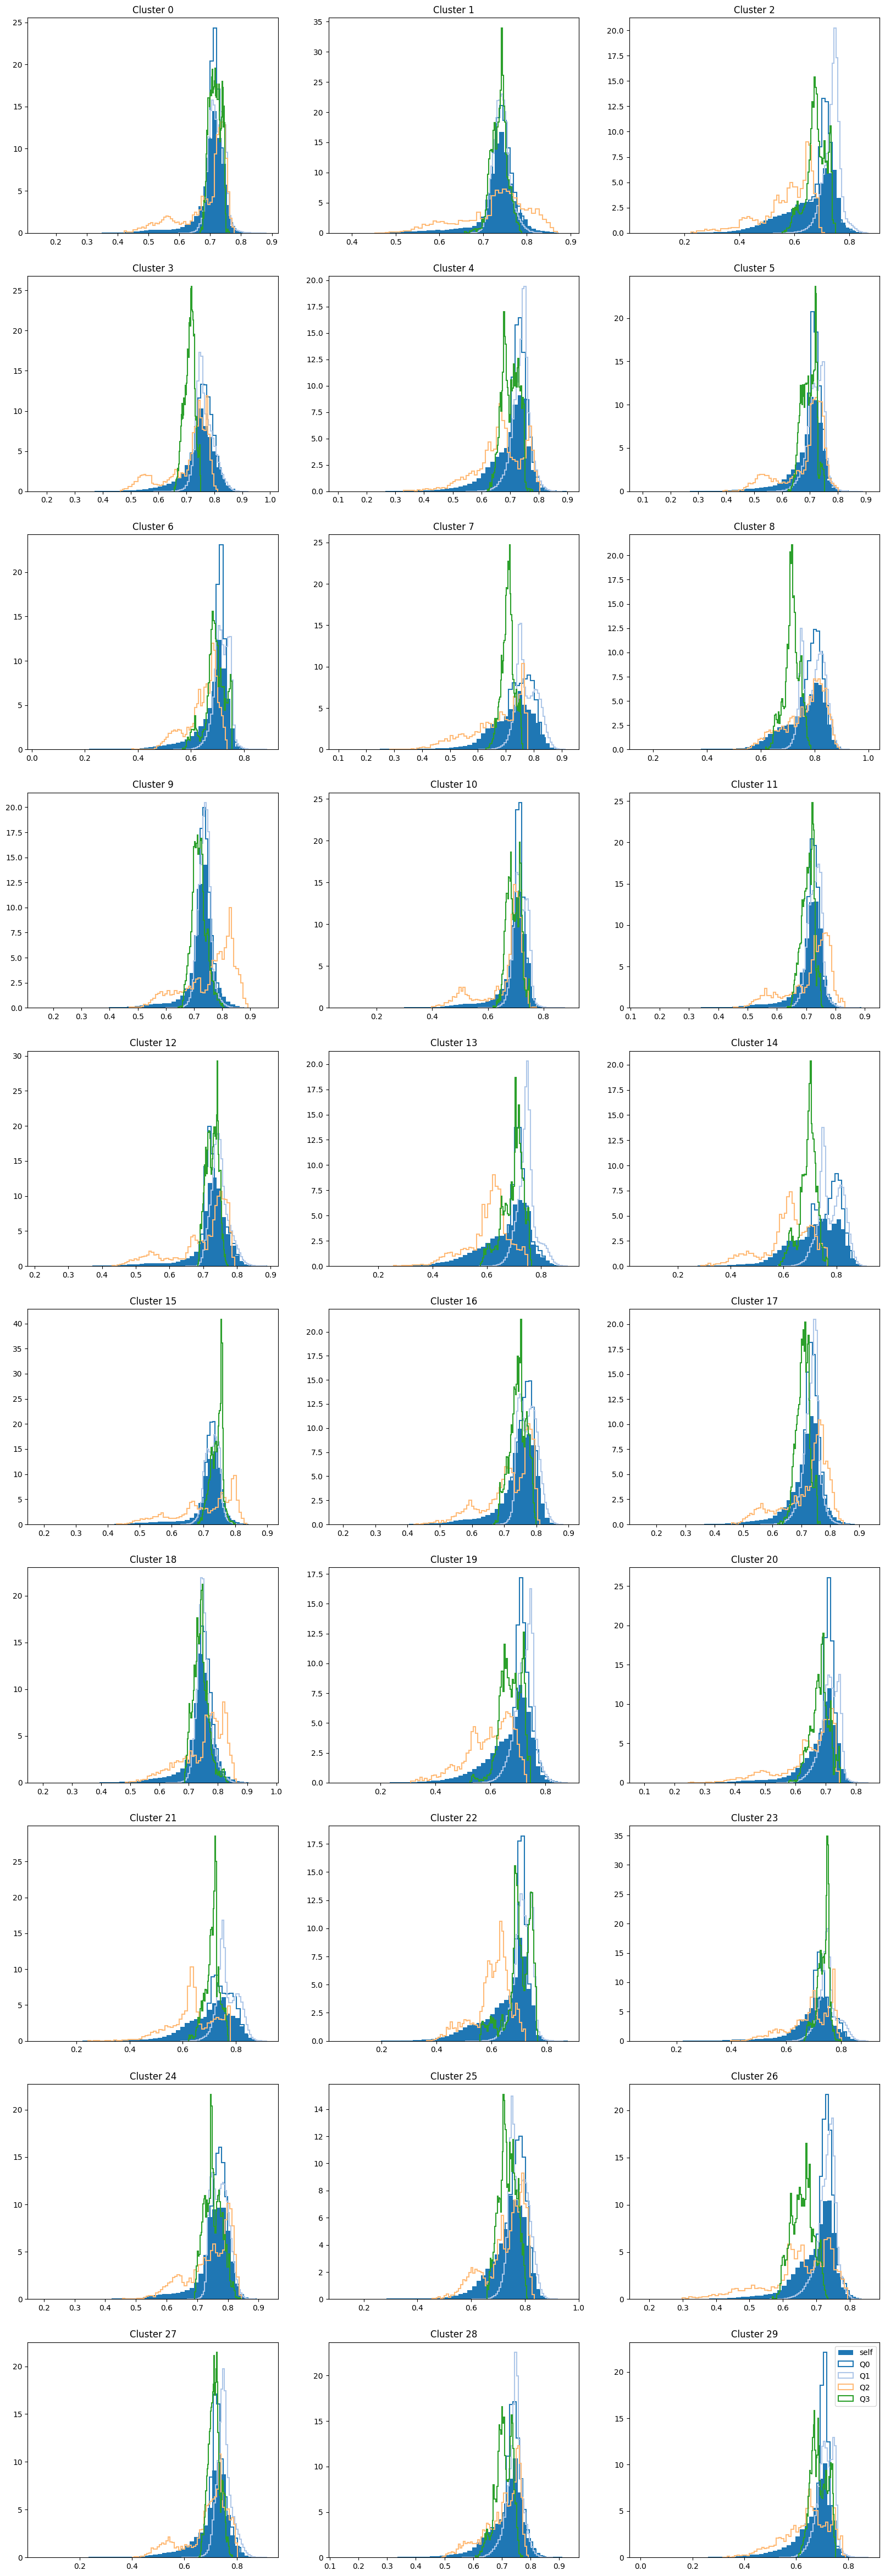

In [243]:
plot_clusters(data_t2m, assigments_t2m)

In [32]:
# bins = 10
# # plt.hist(clusters,label="All", histtype='step', bins=bins)
# plt.hist( elnino[elnino['indicator']==1]['cluster'],label="El Nino", histtype='step')
# plt.hist( elnino[elnino['indicator']==2]['cluster'],label="La Nina", histtype='step',bins=bins)
# plt.hist( elnino[elnino['indicator']==0]['cluster'],label="None", histtype='step',bins=bins)

# plt.xlabel('Cluster')
# plt.ylabel('Frequency')
# plt.title('Histogram of Clusters')
# plt.legend()
# plt.show()

In [33]:
# daily_data  = elnino.resample('D')[['cluster']].agg(lambda x: x.mode()[0])
# daily_data = daily_data.join(elnino['indicator'])

In [34]:
# daily_data['MONTH'] = daily_data.index.month
# daily_data_count = daily_data.groupby(['MONTH','indicator'])['cluster'].value_counts().unstack().fillna(0)
# daily_data_count

In [35]:
# fig, ax = plt.subplots(4,3,figsize=(20,12))

# for i in range(1,13):
#     daily_data_count.loc[i].T.replace(0,np.nan).dropna()\
#         .plot(kind='bar',
#               ax=ax[(i-1)//3,(i-1)%3],
#               stacked=False,
#               title=f'Month {i}')
    
#     ax[(i-1)//3,(i-1)%3].set_xlabel('')

# plt.show()

# # daily_data_count.loc[1].T.replace(0,np.nan).dropna().plot(kind='bar',stacked=False)

In [36]:
# bins = 10
# # plt.hist(clusters,label="All", histtype='step', bins=bins)
# plt.hist( daily_data[daily_data['indicator']==1]['cluster'],label="El Nino", histtype='step')
# plt.hist( daily_data[daily_data['indicator']==2]['cluster'],label="La Nina", histtype='step',bins=bins)
# plt.hist( daily_data[daily_data['indicator']==0]['cluster'],label="None", histtype='step',bins=bins)

# plt.xlabel('Cluster')
# plt.ylabel('Frequency')
# plt.title('Histogram of Clusters')
# plt.legend()
# plt.show()

In [37]:
# clusters = pd.DataFrame(clusters,index=timseries,columns=['Assigments'])
# prop_count = clusters.groupby(pd.Grouper(freq='M'))['Assigments'].value_counts().to_frame().unstack().fillna(0)

# blocks = 3
# fig, axs = plt.subplots(math.ceil(len(prop_count.columns) / blocks), blocks, figsize=(20, 25))  # Two columns of subplots

# for idx, col in enumerate(prop_count.columns):
#     row = idx // blocks
#     col_idx = idx % blocks
    
#     prop_count.rolling(12).mean()[col].dropna().plot(ax=axs[row, col_idx])
#     prop_count.rolling(12*5).mean()[col].dropna().plot(ax=axs[row, col_idx],secondary_y=True)
#     prop_count.rolling(12*10).mean()[col].dropna().plot(ax=axs[row, col_idx],secondary_y=True)
    
#     axs[row, col_idx].set_title(f'Cluster {idx}')
    
# plt.tight_layout()
# plt.show()